In [41]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv("train.csv")

df.drop_duplicates()
df.isna().sum()

passenger_id      0
pclass            0
name              0
sex               0
age             174
sibsp             0
parch             0
ticket            0
fare              1
cabin           659
embarked          1
boat            542
body            777
home.dest       386
survived          0
dtype: int64

Handled all the null values except for home.dest

and also removed the rows with null value in fare and embarked as they only have one null value so removing it doesnt make any or less significant difference

In [43]:
df = df.dropna(subset=['fare','embarked'])

df[['age']] = df[['age']].fillna(df[['body', 'age']].mean())
df[['cabin','boat','body']] = df[['cabin','boat','body']].fillna(0)
df.isna().sum()

passenger_id      0
pclass            0
name              0
sex               0
age               0
sibsp             0
parch             0
ticket            0
fare              0
cabin             0
embarked          0
boat              0
body              0
home.dest       384
survived          0
dtype: int64

In [44]:
encoder = OneHotEncoder(sparse_output=False)
encoded_columns = encoder.fit_transform(df[['sex', 'pclass', 'embarked']])

encoded_df = pd.DataFrame(
    encoded_columns, 
    columns=encoder.get_feature_names_out(['sex', 'pclass', 'embarked'])
)

df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
df = df.drop(['sex', 'pclass', 'embarked'], axis=1)

df.to_csv('encoded.csv')


Feature Engineering

also extracted the Titles from their names as it may be significant such as a Colonel married to a mrs with less impact but it makes impact

remoed the home.dest as it may not contribute to the survivability

found the family size of each person this helps in removing the outliers such as more family members or siblings

and also found if the passsenger is alone or travelling with his family based on the sibsp and parch columns


In [45]:
df = df.drop(['home.dest'],axis=1)
df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)


df['familysize'] = df['sibsp'] + df['parch'] + 1

df['isalone'] = (df['familysize'] == 1).astype(int)

df.to_csv('encoded.csv')


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Jedi\AppData\Local\Temp\ipykernel_21428\4200783666.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['title'] = df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [46]:
num_cols = ['age', 'fare', 'body']

for column in num_cols:
    lower_percentile = df[column].quantile(0.01)
    upper_percentile = df[column].quantile(0.99)
    df[column] = df[column].clip(lower=lower_percentile, upper=upper_percentile)

df.to_csv('encoded.csv')


In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('encoded.csv')

label_encoder = LabelEncoder()
df['name'] = label_encoder.fit_transform(df['name'])
df['title'] = label_encoder.fit_transform(df['title'])
df['cabin'] = label_encoder.fit_transform(df['cabin'])
df['boat'] = label_encoder.fit_transform(df['boat'])

df = df.drop(columns=['ticket', 'embarked_C', 'embarked_Q', 'embarked_S'])


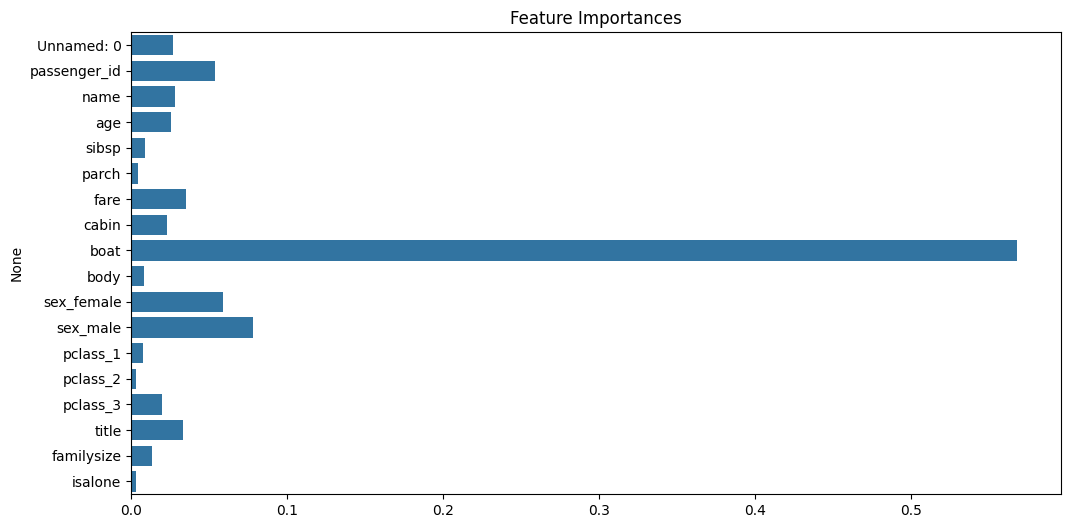

In [48]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['survived'])
y = df['survived']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.show()


Dropping columns with 0 variance


In [49]:
df = df.loc[:, df.var() != 0]


selecting upper triangle in the correlation matrix and finding the features that are greater correlation than .95

In [50]:
import numpy as np

corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

df_reduced = df.drop(columns=to_drop)
print(df_reduced.head())

df_reduced.to_csv('reduced_encoded.csv', index=False)


   Unnamed: 0  passenger_id  name        age  sibsp  parch     fare  cabin  \
0           0          1216   735  29.461301      0      0   7.7333      0   
1           1           699   123  38.000000      0      0   8.6625      0   
2           2          1267   781  30.000000      1      1  24.1500      0   
3           3           449   360  54.000000      1      3  23.0000      0   
4           4           576   790  40.000000      0      0  13.0000      0   

   boat  body  survived  sex_female  pclass_1  pclass_2  pclass_3  title  \
0     5   0.0         1         1.0       0.0       0.0       1.0      7   
1     0   0.0         0         0.0       0.0       0.0       1.0     10   
2     0   0.0         0         1.0       0.0       0.0       1.0     11   
3    14   0.0         1         1.0       0.0       1.0       0.0     11   
4     0   0.0         0         0.0       0.0       1.0       0.0     10   

   familysize  isalone  
0           1        1  
1           1        1  

the barplot shows all the important features and how they contribute with respect to trgat variable after reduing dimensionality


In [51]:

X = df_reduced.drop(columns=['survived'])
y = df_reduced['survived']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [52]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           1       0.98      0.94      0.96        68

    accuracy                           0.97       170
   macro avg       0.97      0.97      0.97       170
weighted avg       0.97      0.97      0.97       170

